# <center>Group Project 2: Regression and Page Rank</center>
## <center>Josh Melton and Ivan Benitez</center>  

### Part 1: Linear Regression and KNN implementation
#### 1.1) Hourly Data
##### a) Data preparation
First, read the hourly bike data csv into a pandas dataframe:
- Set the column names
- Index using the 'instant' column
- Parse the date column

In [1]:
import pandas as pd

hourly_data = pd.read_csv('Bike-Sharing-Dataset/hour.csv',
                          header=0, index_col=0,
                          parse_dates=[1])
# hourly_data.info()

Extract feature set by removing the date column and the label columns.  
Store the column name for each label vector.

In [2]:
features = hourly_data.drop(['dteday', 'casual', 'registered', 'cnt'], axis=1)
label_cols = ['casual', 'registered', 'cnt']

##### b) Feature correlation with labels

Calculate the correlation of each feature with the label vectors.  
Plot the four features with the highest correlation with each label vector.

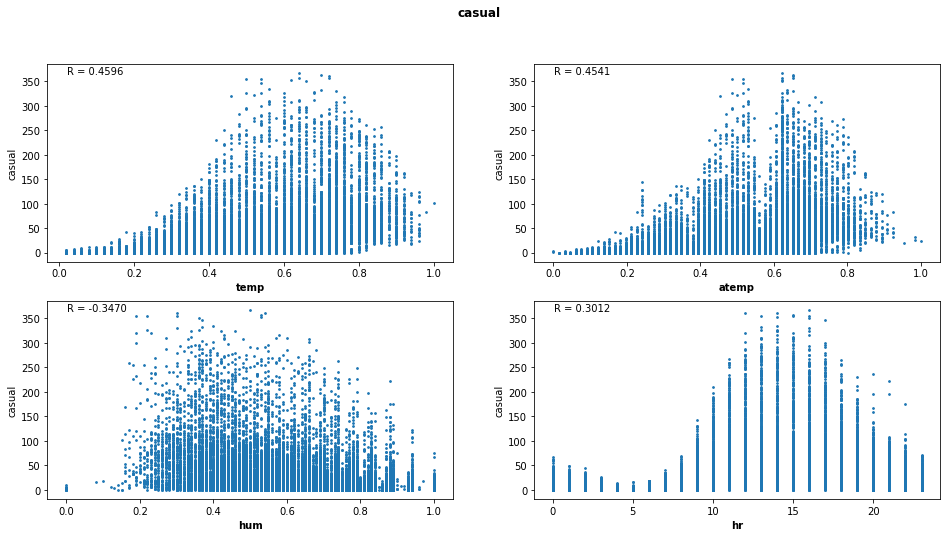

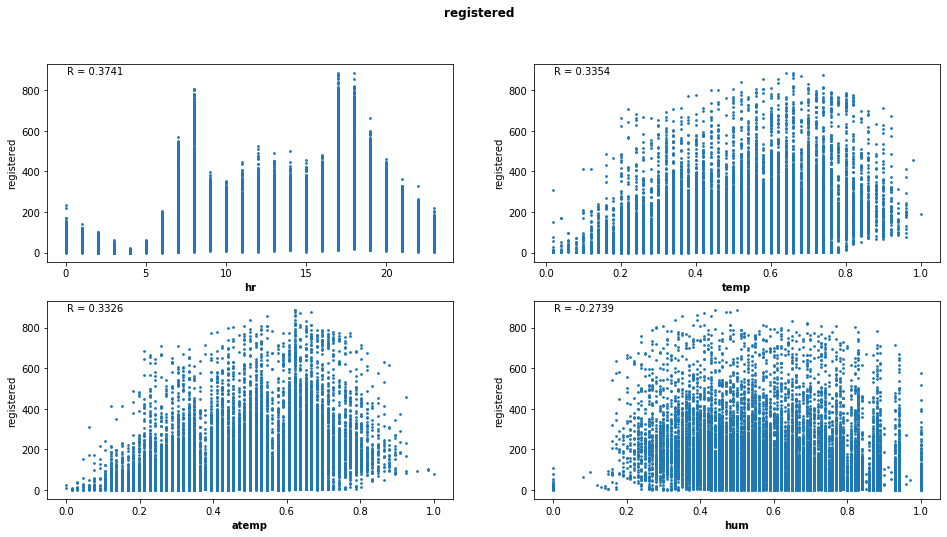

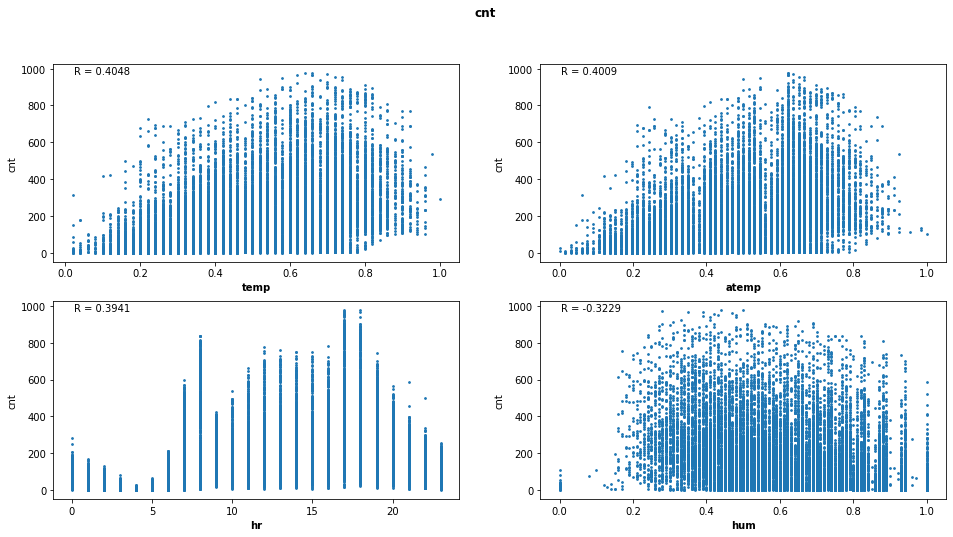

In [6]:
import matplotlib.pyplot as plt

features_subset_cols = []
for lab in label_cols:
    labels = hourly_data[lab]

    # Calculate how correlated each feature is with the labels
    corrs = features.corrwith(labels, axis=0,
                              method='pearson')
    # Sort by absolute value of correlation
    order = corrs.abs().sort_values(ascending=False)
    corrs = corrs[order.index]
    # print(corrs)

    # Extract the 5 feature names with highest correlation for each label
    features_subset_cols.append(corrs.index[:5].tolist())
    
    # Plot scatter plot of 4 features with highest correlations
    fig, ax = plt.subplots(2, 2, figsize=(16, 8))
    ind = 0
    for row in [0, 1]:
        for col in [0, 1]:
            df_col = corrs.index[ind]
            ax[row, col].scatter(features[df_col], labels, s=3)

            ax[row, col].set_xlabel(df_col, fontweight='bold')
            ax[row, col].set_ylabel(lab)

            ax[row, col].text(0.05, 0.95, 'R = {:.4f}'.format(corrs[ind]),
                              transform=ax[row, col].transAxes)
            ind += 1
    fig.suptitle(lab, fontweight='bold')
    plt.show()

##### c) Linear Regression Models
Fit linear regression models using:
1. The single most correlated feature with the labels
2. The five features most highly correlated with the labels
3. The entire feature set (12 features)

In [4]:
import math
import sklearn.model_selection as ms
from sklearn import metrics
from sklearn.linear_model import LinearRegression


def print_metrics(y_true, y_preds):
    mse = metrics.mean_squared_error(y_true, y_preds)
    print('\tMean Square Error      = {:.3f}'.format(mse))
    print('\tRoot Mean Square Error = {:.3f}'.format(math.sqrt(mse)))
    print('\tMean Absolute Error    = {:.3f}'.format(metrics.mean_absolute_error(y_true, y_preds)))
    print('\tMedian Absolute Error  = {:.3f}'.format(metrics.median_absolute_error(y_true, y_preds)))
    print('\tR^2                    = {:.3f}'.format(metrics.r2_score(y_true, y_preds)))


string_dict = {0: 'Single most correlated feature:',
               1: 'Five column subset:',
               2: 'Full feature set:'}

print('Linear Regression models:\n')
for i, lab in enumerate(label_cols):
    labels = hourly_data[lab]
    
    best_feature_name = features_subset_cols[i][0]
    best_feature = hourly_data[best_feature_name].values.reshape(-1, 1)
    features_subset = hourly_data[features_subset_cols[i]]

    print('Label column: {}\n'.format(lab))
    for j, f in enumerate([best_feature, features_subset, features]):
        X_train, X_test, y_train, y_test = ms.train_test_split(f, labels,
                                                               test_size=0.2,
                                                               random_state=123)
        
        print(string_dict[j], best_feature_name) if j == 0 else print(string_dict[j])
        
        lin_reg = LinearRegression()
        lin_reg.fit(X_train, y_train)
    
        lin_preds = lin_reg.predict(X_test)
        print_metrics(y_test, lin_preds)
        print()
    print('-' * 50)

Linear Regression models:

Label column: casual

Single most correlated feature: temp
	Mean Square Error      = 2006.462
	Root Mean Square Error = 44.794
	Mean Absolute Error    = 28.219
	Median Absolute Error  = 18.137
	R^2                    = 0.197

Five column subset:
	Mean Square Error      = 1454.804
	Root Mean Square Error = 38.142
	Mean Absolute Error    = 25.436
	Median Absolute Error  = 17.655
	R^2                    = 0.418

Full feature set:
	Mean Square Error      = 1418.171
	Root Mean Square Error = 37.659
	Mean Absolute Error    = 25.295
	Median Absolute Error  = 17.417
	R^2                    = 0.433

--------------------------------------------------
Label column: registered

Single most correlated feature: hr
	Mean Square Error      = 20190.686
	Root Mean Square Error = 142.094
	Mean Absolute Error    = 102.487
	Median Absolute Error  = 78.080
	R^2                    = 0.131

Five column subset:
	Mean Square Error      = 16571.707
	Root Mean Square Error = 128.731
	Me

##### c) KNN Regression Models
Fit KNN regression models using:
1. The single most correlated feature with the labels
2. The five features most highly correlated with the labels
3. The entire feature set (12 features)

Use cross validation to determine the best k value for each model, refitting based on the Mean Squared Error.

In [5]:
from sklearn.neighbors import KNeighborsRegressor

print('KNN Regression models:\n')
for i, lab in enumerate(label_cols):
    labels = hourly_data[lab]
    
    best_feature_name = features_subset_cols[i][0]
    best_feature = hourly_data[best_feature_name].values.reshape(-1, 1)
    features_subset = hourly_data[features_subset_cols[i]]

    print('Label column: {}\n'.format(lab))
    for j, f in enumerate([best_feature, features_subset, features]):
        X_train, X_test, y_train, y_test = ms.train_test_split(f, labels,
                                                               test_size=0.2,
                                                               random_state=123)
        
        print(string_dict[j], best_feature_name) if j == 0 else print(string_dict[j])
        
        knn_reg = ms.GridSearchCV(KNeighborsRegressor(),
                                  param_grid={'n_neighbors': range(1, 30, 2)},
                                  cv=5, scoring='neg_mean_squared_error',
                                  refit=True)
        knn_reg.fit(X_train, y_train)
        print('\tBest k:', knn_reg.best_params_)
    
        knn_preds = knn_reg.predict(X_test)
        print_metrics(y_test, knn_preds)
        print()
    print('-' * 50)

KNN Regression models:

Label column: casual

Single most correlated feature: temp
	Best k: {'n_neighbors': 27}
	Mean Square Error      = 2005.579
	Root Mean Square Error = 44.784
	Mean Absolute Error    = 27.083
	Median Absolute Error  = 16.815
	R^2                    = 0.198

Five column subset:
	Best k: {'n_neighbors': 21}
	Mean Square Error      = 533.760
	Root Mean Square Error = 23.103
	Mean Absolute Error    = 13.095
	Median Absolute Error  = 6.048
	R^2                    = 0.786

Full feature set:
	Best k: {'n_neighbors': 5}
	Mean Square Error      = 331.206
	Root Mean Square Error = 18.199
	Mean Absolute Error    = 10.341
	Median Absolute Error  = 4.800
	R^2                    = 0.867

--------------------------------------------------
Label column: registered

Single most correlated feature: hr
	Best k: {'n_neighbors': 29}
	Mean Square Error      = 11465.860
	Root Mean Square Error = 107.079
	Mean Absolute Error    = 72.467
	Median Absolute Error  = 44.241
	R^2               